# データ拡張します。


In [1]:
from Union import *
from UnionKit import *
import cv2
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import os
import csv
import sys 
sys.path.append("../Tools/ToolKit/")
import KSImageKit as KS
import KagamiDevKit as KD
import tensorflow as tf
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn import preprocessing
#コマンドライン引数
flags = tf.app.flags
%matplotlib  inline

In [2]:
def count_files(in_directory):
    joiner= (in_directory + os.path.sep).__add__
    return sum(
        os.path.isfile(filename)
        for filename
        in map(joiner, os.listdir(in_directory))
    )
def darkmode(tar):
    img=cv2.imread(tar)
    h,w,_=img.shape

    blur=w/150
    if(blur%2==0):
        blur+=1

    img=TargetSmoothingBlur(img,blur)
    # display_cv_image(img)
    img=LensFilter(img,"blue",1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil=Image.fromarray(img)
    img=PIL_point(0.6,pil)
    #PILからOpenCVへ変換
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    img=ModChroma(img,5)

    img=OpenCV_gamma(0.6,img)
    return img


In [3]:
class ZCAWhitening:
  def __init__(self, epsilon=1E-6):
    self.epsilon = epsilon
    self.mean = None
    self.zca = None
  
  def fit(self, x):
    self.mean = np.mean(x, axis=0)
    x_ = x - self.mean
    cov = np.dot(x_.T, x_) / x_.shape[0]
    E, D, _ = np.linalg.svd(cov)
    D = np.sqrt(D) + self.epsilon
    self.zca = np.dot(E, np.dot(np.diag(1.0 / D), E.T))

    return self
  
  def transform(self, x):
    x_ = x - self.mean
    return np.dot(x_, self.zca.T)

In [4]:
##source:http://kikei.github.io/ai/2018/03/28/cifar10-whitening.html

In [5]:
# 正規化
def normalizeMinMax(x, axis=0, epsilon=1E-5) :
  vmin = np.min(x, axis)
  vmax = np.max(x, axis)
  return (x - vmin) / (vmax - vmin + epsilon)

def normalizeImage(x):
  img = x.reshape(x.shape[0] * x.shape[1], x.shape[2])
  img = normalizeMinMax(img, axis=0)
  return img.reshape(x.shape)


In [6]:
#イニシャライズ#
#入力ディレクトリ
INPUT_DIR="../datasets/ProjectDatasetFactory/Load_set2_BAK/imgs/"
#出力ディレクトリ
OUTPUT_DIR=INPUT_DIR
#アノテーションファイル
ANNOTATION_FILE="../datasets/ProjectDatasetFactory/Load_set2_BAK/Load_set_annotation.csv"

image_data=csv_read(ANNOTATION_FILE,"utf-8")

print("DEBUG:INPUT_"+image_data[1][5])
print("DEBUG:OUTPUT_"+OUTPUT_DIR+"AG_"+image_data[1][6])


DEBUG:INPUT_/home/kagamiwomiru/datasets/ProjectDatasetFactory/Load_set2/imgs/out_label_1_0.jpg
DEBUG:OUTPUT_../datasets/ProjectDatasetFactory/Load_set2_BAK/imgs/AG_out_label_1_0.jpg


In [8]:
# 画像データ読み込み
print("画像を読み込み中")
KS.size_unification(INPUT_DIR,"../datasets/ProjectDatasetFactory/tmp/",size=96,mode='edge')


画像を読み込み中


TypeError: an integer is required

In [8]:
ImageData=KS.LoadData_LikeCifar10("../datasets/ProjectDatasetFactory/tmp/")

In [9]:
x_train = ImageData.astype('float32') / 255

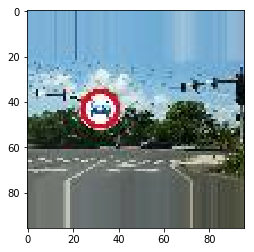

In [10]:
plt.clf()
plt.imshow(x_train[6,:,:,:])

In [11]:
x_train_std = np.zeros(x_train.shape)
for i in range(0, x_train.shape[0]):
    for j in range(0, x_train.shape[3]):
        x_train_std[i,:,:,j] = preprocessing.scale(x_train[i,:, :,j])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


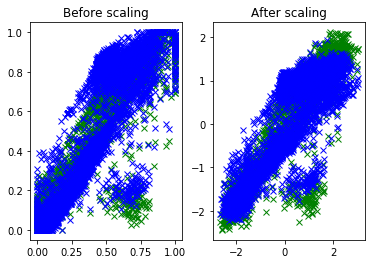

In [12]:
idx = 6
plt.clf()
plt.subplot(1, 2, 1)
plt.title('Before scaling')
plt.plot(x_train[idx,:,:,0].flatten(), x_train[idx,:,:,1].flatten(), 'gx')
plt.plot(x_train[idx,:,:,0].flatten(), x_train[idx,:,:,2].flatten(), 'bx')

plt.subplot(1, 2, 2)
plt.title('After scaling')
plt.plot(x_train_std[idx,:,:,0].flatten(),
         x_train_std[idx,:,:,1].flatten(), 'gx')
plt.plot(x_train_std[idx,:,:,0].flatten(), 
         x_train_std[idx,:,:,2].flatten(), 'bx')

In [ ]:
x_zcaw = x_train.reshape(x_train.shape[0], -1)
zcaw = ZCAWhitening().fit(x_zcaw)
x_zcaw = zcaw.transform(x_zcaw).reshape(x_train.shape)
plt.clf()
for i in range(0, 16):
  plt.subplot(4, 8, i*2+1)
  fig = plt.imshow(x_train[i,:,:,:])
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.subplot(4, 8, i*2+2)
  fig = plt.imshow(normalizeImage(x_zcaw[i,:,:,:]))
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)

In [ ]:
%%bash
echo "OK" | /home/kagamiwomiru/Tools/notiSlack.sh

In [ ]:
plt.imshow(x_train[0,:,:,:])

In [ ]:
plt.imshow(normalizeImage(x_zcaw[0,:,:,:]))

In [13]:
  image_data = csv_read("../datasets/ProjectDatasetFactory/Load_set2_BAK/Load_set_annotation.csv", "utf-8")

In [14]:
image_data[0]

[u'label', u'minX', u'minY', u'maxX', u'maxY', u'path', u'file', u'name']

In [31]:
len(image_data[7])

8

In [17]:
str(None)

'None'

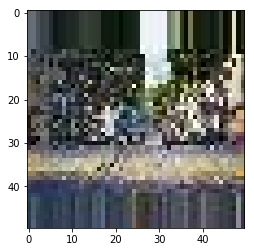

In [7]:
plt.imshow(plt.imread("/home/kagamiwomiru/datasets/ProjectDatasetFactory/tmp/?.jpg"))


In [9]:
import cv2
from IPython.display import display, Image as iP
#画像表示用
import matplotlib.pyplot as plt
def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(iP(data=decoded_bytes))

In [10]:
  image_data = csv_read("../datasets/ProjectDatasetFactory/Load_set2_BAK/Load_set_annotation.csv", "utf-8")

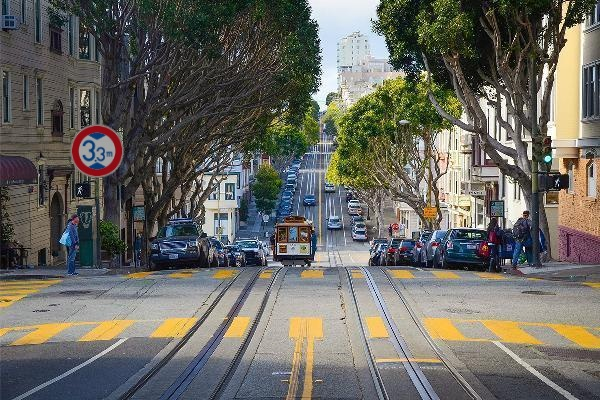

In [11]:
img=cv2.imread(image_data[1][5])
display_cv_image(img)

In [12]:
image_data[1][2]

u'122'

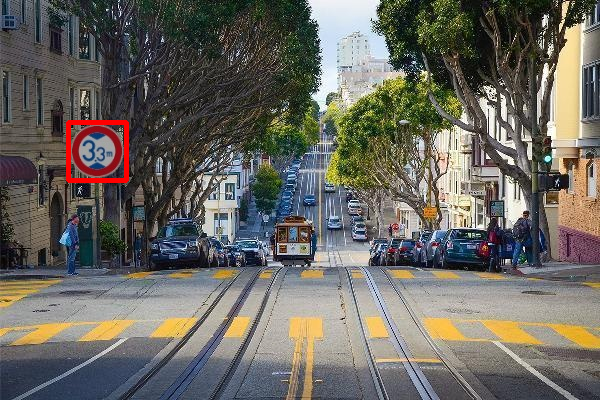

In [13]:
display_cv_image(cv2.rectangle(img, (int(image_data[1][1]),int(image_data[1][2])),(int(image_data[1][3]),int(image_data[1][4])),(0,0,255),3))

In [14]:
#縮小してもバウンディングボックスが正しいか

In [15]:
KS.image_square(image_data[1][5],
                               "/home/kagamiwomiru/datasets/ProjectDatasetFactory/tmp/",size=50,mode='edge')

In [16]:
tiny=cv2.imread("/home/kagamiwomiru/datasets/ProjectDatasetFactory/tmp/?.jpg")

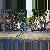

In [17]:
display_cv_image(tiny)

In [18]:
org=plt.imread(image_data[1][5])

In [19]:
org=np.asarray(org)
org.flags.writeable=True

In [20]:
org.shape

(400, 600, 3)

In [21]:
tinyShape=[0] *3
for i in range(0,2):
    tinyShape[i]= org.shape[i] /  tiny.shape[i] 

In [22]:
tinyShape #tiny画像の何倍サイズか（y、x、c）

[8, 12, 0]

In [23]:
x=image_data[1][1]
y=image_data[1][2]

In [28]:
min_x=int(image_data[1][1]) / tinyShape[1]
min_y=int(image_data[1][2]) / tinyShape[0]
max_x=int(image_data[1][3]) / tinyShape[1]
max_y=int(image_data[1][4]) / tinyShape[0]

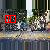

In [29]:
display_cv_image(cv2.rectangle(tiny, (min_x,min_y),(max_x,max_y),(0,0,255),1))